The objective funciton:
$$\underset{\theta}{\max}\sum_{i}\log p_{\theta}(x^{(i)})=\underset{\theta}{\max}\sum_{i}\log p_{Z}(f_{\theta}(x^{(i)}))+\log\left|\cfrac{\partial f_{\theta}}{\partial x}(x^{(i)})\right| $$



In [ ]:
from train import *

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test = 2000, 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_flow_demo_1(n_train, n_test,
            loader_args, visualize=True, train_only=False)


cdf_flow_model = MixtureCDFFlow(base_dist='uniform', mixture_dist='gaussian',
                    n_components=5).to(ptu.device)
cdf_flow_model_old = copy.deepcopy(cdf_flow_model)
train_epochs(cdf_flow_model, train_loader, test_loader,
                      dict(epochs=50, lr=5e-3, plot=False))
visualize_demo1_flow(train_loader, cdf_flow_model_old, cdf_flow_model)

ud = Uniform(torch.FloatTensor([0.0]), ptu.FloatTensor([1.0]))
z = ud.rsample(torch.IntTensor([1000]))
x = cdf_flow_model.invert(z);
plt.figure();
plt.hist(ptu.get_numpy(x), bins=50);

It is clear that the gradident is only depend on the Cross-Entropy part.

Therefore, the objective function is:

$$\begin{align}
\underset{\theta}{\min}D_{\mathbb{KL}}(p||q;\theta)&=\underset{\theta}{\min}-\mathbb{\mathbb{E}}_{x\sim q(X;\theta)}\cfrac{p(X)}{q(X;\theta)}\log q(X;\theta) \\
&=\underset{\theta}{\min}-\mathbb{\mathbb{E}}_{x\sim q(X;\theta)}\cfrac{f(X)/c}{q(X;\theta)}\log q(X;\theta) \\
&=\underset{\theta}{\min}-\mathbb{\mathbb{E}}_{x\sim q(X;\theta)}\cfrac{f(X)}{q(X;\theta)}\log q(X;\theta)
	\end{align}$$

where $c$ is the normalizing constant, $f(X)$ is the target function, $q(X;\theta)$ can be estimated using flow model, and the samples are generated from the flow model.

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

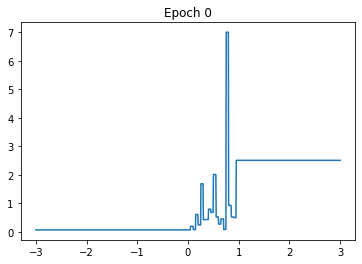

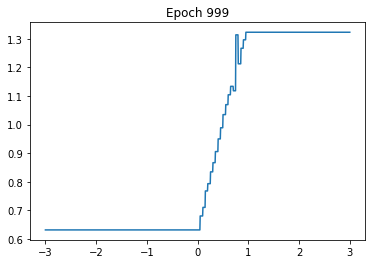

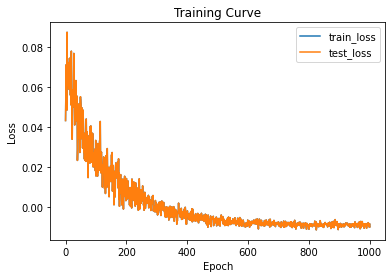

<Figure size 432x288 with 0 Axes>

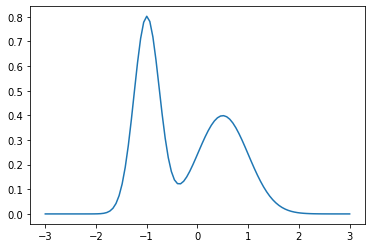

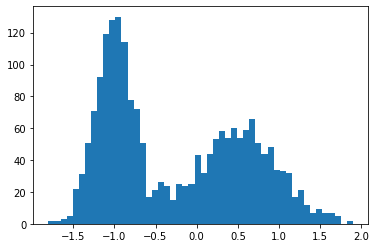

In [2]:
from train3 import *
from torch.distributions.normal import Normal

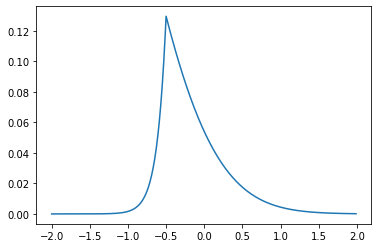

In [3]:
m1 = Normal(torch.tensor([-2]), torch.tensor([1]))
eventLevel = torch.FloatTensor([-0.5])
rho = lambda x : torch.where(x < eventLevel,  
                10*(eventLevel - x), torch.FloatTensor([0]))
def f(x):
    return (m1.log_prob(x) - rho(x)).exp()

x = torch.arange(-2, 2, 0.01)
y = f(x)
plt.plot(x, y)

/var/folders/kb/jnvlsd896tj2g_5wz25rg9t00000gn/T/ipykernel_10058/791097898.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

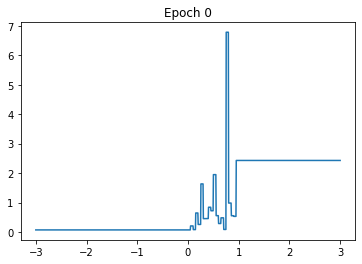

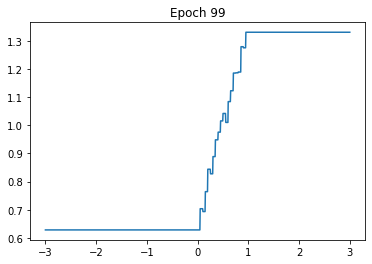

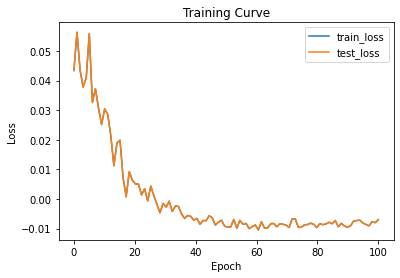

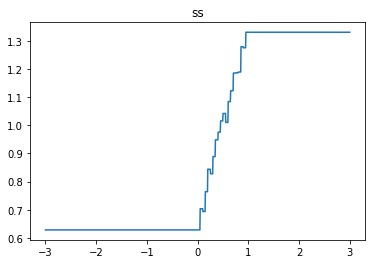

In [6]:
from MixtureCDFFlow import *
from torch.distributions.normal import Normal

d_target = Normal(torch.tensor([2.0]), torch.tensor([1.0]))


# applies gradient steps for each mini-batch in an epoch
def train(model, optimizer):
    model.eval()
    x = model.sample(n_xsize)
    x = x.to(ptu.device).float()

    model.train()
    fx = d_target.log_prob(x).exp()
    loss = model.kl(x, fx)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def train_epochs(model, train_args):
    # training parameters
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # plotting parameters
    plot = train_args.get('plot', True)
    plot_frequency = train_args.get('plot_frequency', 5)
    if 'epochs_to_plot' in train_args.keys():
        plot_frequency = epochs + 1
        epochs_to_plot = train_args['epochs_to_plot']
    else:
        epochs_to_plot = []

    train_losses, test_losses = [], []
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        train_loss = train(model, optimizer)
        train_losses.append(train_loss)

        if plot and (epoch % plot_frequency == 0 or epoch in epochs_to_plot):
            model.plot(f'Epoch {epoch}')

    if plot:
        plot_train_curves(epochs, train_losses, train_losses, title='Training Curve')
    return train_losses, train_losses

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)

n_xsize=1000

cdf_flow_model = MixtureCDFFlow(n_xsize=n_xsize, base_dist='uniform', mixture_dist='gaussian',
                    n_components=20).to(ptu.device)
cdf_flow_model_old = copy.deepcopy(cdf_flow_model)
eps = 100
train_epochs(cdf_flow_model, dict(epochs=eps, lr=5e-2, epochs_to_plot=[0,eps-1]))

cdf_flow_model.plot("ss")

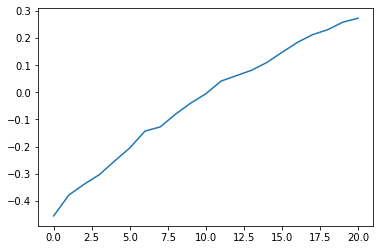

In [2]:
plt.plot(cdf_flow_model.weight_.detach().numpy())